In [1]:
import os

os.chdir("../")

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

from face_tagging.get_keypoints import get_keypts

In [2]:
TRAIN_IMAGES_DIR = "./resources/train_images"

In [3]:
images = os.listdir(TRAIN_IMAGES_DIR); images

['image2.jpg',
 'image10.jpg',
 'image4.jpg',
 'image6.jpg',
 'image5.jpg',
 'image8.jpg',
 'image7.jpg',
 'image3.jpg',
 'image9.jpg',
 'image1.jpg']

In [4]:
images_to_keypoints = dict()

for image in images:
    url = os.path.join(TRAIN_IMAGES_DIR, image)
    result = get_keypts(url, silent=False)
    if result is not None:
        images_to_keypoints[image] = result

Something went wrong
Something went wrong
Something went wrong


In [5]:
df = pd.DataFrame.from_dict(images_to_keypoints)
df = df.transpose()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
image2.jpg,-0.185909,0.067868,0.039309,-0.082200,-0.086981,0.039979,-0.029991,-0.057583,0.140435,-0.143214,...,0.081886,-0.026868,0.062151,-0.064383,-0.144577,-0.184796,0.064035,-0.082566,0.167055,0.036307
image10.jpg,-0.163997,0.032625,0.132290,-0.138209,-0.069839,-0.088106,-0.052248,-0.176265,0.139457,-0.155102,...,0.048913,0.044040,0.067779,-0.062480,-0.095175,-0.077019,0.047777,-0.089953,0.064141,0.026908
image4.jpg,-0.155427,0.047399,0.005643,0.037812,-0.044404,-0.068241,-0.026556,-0.203503,0.097148,-0.035472,...,0.081202,0.079869,0.000999,0.040762,-0.129067,-0.083390,0.043762,-0.099999,0.168648,0.028903
image6.jpg,-0.005563,0.016488,0.036630,-0.125987,-0.078083,0.022831,-0.038736,-0.041771,0.222424,-0.035011,...,0.065053,0.047178,0.099247,0.113197,-0.149545,-0.132866,-0.005378,-0.004147,0.121249,0.068118
image8.jpg,-0.159116,0.025757,0.089369,-0.116362,-0.129103,-0.065410,-0.058841,-0.124685,0.174449,-0.191225,...,0.074093,0.030151,0.085750,-0.088163,-0.116954,-0.124739,0.039270,-0.035256,0.086318,0.072636


In [6]:
df.to_csv("resources/csv/key_points.csv")

In [6]:
"""
Getting indices to train and predict on, using sklearn.model_selection.LeaveOneOut.split()
LeaveOnOut.split() returns one index for testing and remaining for training
it returns in the order of train indices followed by the single test index
in our case, we require the opposite, and hence we consider it as predict indices followed by the train index
"""
kf_loo = LeaveOneOut()

for predict_indices, train_index in kf_loo.split(df):
    print("Train:", train_index, "Test:", predict_indices)

Train: [0] Test: [1 2 3 4 5 6]
Train: [1] Test: [0 2 3 4 5 6]
Train: [2] Test: [0 1 3 4 5 6]
Train: [3] Test: [0 1 2 4 5 6]
Train: [4] Test: [0 1 2 3 5 6]
Train: [5] Test: [0 1 2 3 4 6]
Train: [6] Test: [0 1 2 3 4 5]


In [7]:
"""
Optimised version of KNN training
"""

knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', weights='distance')
le = LabelEncoder()

# dict to store the grouped clusters, classNum is the cluster number
# groupedClasses will store the groups in the format:
# {
#   0: [image_name_1, image_name_2, image_name_3],
#   1: [image_name_4],
#   2: [image_name_5, image_name_6], ...
# }  where 0, 1, 2, etc are the different class numbers

groupedClasses = dict()
classNum = 0

# a set to store names of already predicted and matched images, so that we don't have to train on it again
matchedImages = set()

new_labels = np.ones(len(df), dtype=int) * -1

# loop over the data to train and predict
for predict_indices, train_index in kf_loo.split(df):
    train_index = train_index[0]
    
    label = df.iloc[train_index].name
    
    # if the label (image) was already predicted and matched before continue without training
    if label in matchedImages:
        continue
        
    label_encoded = le.fit_transform([label])
    
    # fit the KNN model on the single image
    points = df.iloc[train_index]
    knn.fit([points], label_encoded)
    
    # predict using the trained model on remaining indices to get the distances of each point to the trained image
    prediction = knn.kneighbors(df.iloc[predict_indices])    
    distances = prediction[0].flatten()
    
    # create a boolean array to filter out distances <= 0.5
    distanceFilter = distances <= 0.5
    
    # filter out the images and distances using the distance filter
    prediction_labels = np.array(df.iloc[predict_indices].index)
    similarLabels = prediction_labels[distanceFilter]
    similarDistances = distances[distanceFilter]

    # group the trained label and predicted similar labels into one class
    groupedClasses[classNum] = np.array([label])
    new_labels[train_index] = classNum
    
    if len(similarLabels) > 0:        
        groupedClasses[classNum] = np.append(groupedClasses[classNum],similarLabels)
        new_labels[predict_indices] = classNum
        
        print(f"\nKNN Image = {label}")
        matchedImages.add(label)
    classNum += 1
        
    for i in range(len(similarLabels)):
        print(f"Prediction Image = {similarLabels[i]}, Distance(s) = {similarDistances[i]}")
        # Keep track of predicted similar images so as to not train on them again
        matchedImages.add(similarLabels[i])


KNN Image = image10.jpg
Prediction Image = image8.jpg, Distance(s) = 0.4304567133643626
Prediction Image = image9.jpg, Distance(s) = 0.3712867845584891

KNN Image = image4.jpg
Prediction Image = image1.jpg, Distance(s) = 0.34498309915306785


In [8]:
print("Grouped Classes:")
for grp in groupedClasses:
    print(grp,":",groupedClasses[grp])
print()

print("Number of Classes:", classNum)

Grouped Classes:
0 : ['image2.jpg']
1 : ['image10.jpg' 'image8.jpg' 'image9.jpg']
2 : ['image4.jpg' 'image1.jpg']
3 : ['image6.jpg']

Number of Classes: 4


In [9]:

# Training KNN on the full data with increased number of neighbours
knn_full = KNeighborsClassifier(n_neighbors=classNum, algorithm='ball_tree', weights='distance')
knn_full.fit(df, new_labels)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, weights='distance')

In [10]:
"""
Less optimised training of KNN model
"""

knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', weights='distance')
le = LabelEncoder()

matched_pairs = {}
used = []

for row in df.iterrows():
    label = row[0]
    label_encoded = le.fit_transform([label])
    points = row[1]
    knn.fit([points], label_encoded)
    
    i = 1
    for row_ in df.iterrows():
        label_ = row_[0]
        label_encoded_ = le.fit_transform([label_])
        points_ = row_[1]
        
        if label_ != label:
            distance = knn.kneighbors([points_])[0][0][0]
            if distance <= 0.5:
                if label not in matched_pairs:
                    matched_pairs[label] = label_
                    print(f"KNN Image = {label}, Prediction Image = {label_}, Distance = {distance}")

KNN Image = image10.jpg, Prediction Image = image8.jpg, Distance = 0.4304567133643626
KNN Image = image4.jpg, Prediction Image = image1.jpg, Distance = 0.34498309915306785
KNN Image = image8.jpg, Prediction Image = image10.jpg, Distance = 0.4304567133643626
KNN Image = image9.jpg, Prediction Image = image10.jpg, Distance = 0.3712867845584891
KNN Image = image1.jpg, Prediction Image = image4.jpg, Distance = 0.34498309915306785


In [11]:
matched_pairs

{'image10.jpg': 'image8.jpg',
 'image4.jpg': 'image1.jpg',
 'image8.jpg': 'image10.jpg',
 'image9.jpg': 'image10.jpg',
 'image1.jpg': 'image4.jpg'}

<Figure size 720x720 with 0 Axes>

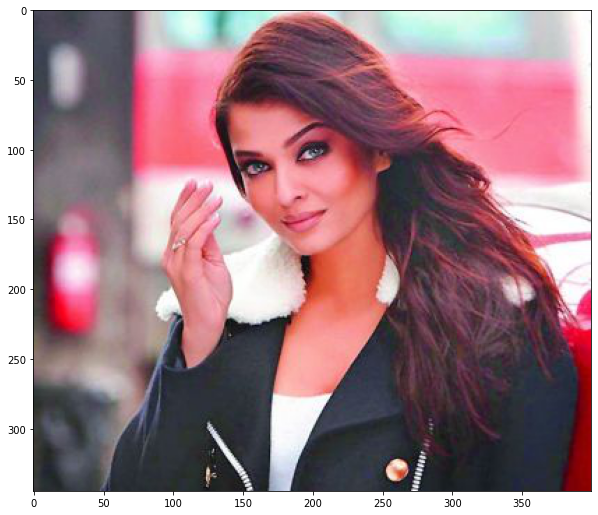

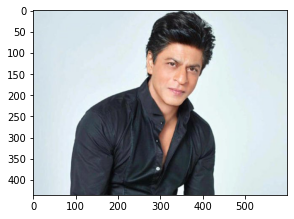

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

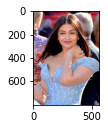

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

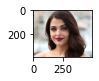

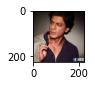

In [27]:
import os

for i, image in enumerate(os.listdir(TRAIN_IMAGES_DIR)):
    fig = plt.figure(figsize=(10, 10))  # width, height in inches
    if image in matched_pairs:
        image = plt.imread(os.path.join(TRAIN_IMAGES_DIR, image))
        sub = fig.add_subplot(i, i, i)
        sub.imshow(image)